In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import scipy as sp

import portfolio_functions as pf
from pandas_datareader import data, wb
import GARCH_MPL as gml

%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


# GARCH

In [31]:
# Simulate GARCH
pars = [0.03123, 0.06123, 0.90123]
sz = 125

# Sim data
sdata = gml.simulate_2(pars, sz)

# Compare Modified Prof. Likelihood with QML 

In [32]:
gml = reload(gml)
qmlHat, mplOHat, mplGHat, mplBHat = gml.get_all_estimators(sdata)

In [33]:
print(pars)
print('-----')
print('qml       %s'%qmlHat)
print('MPL_Omega %s'%mplOHat)
print('MPL_Gamma %s'%mplGHat)
print('MPL_Beta  %s'%mplBHat)

[0.03123, 0.06123, 0.90123]
-----
qml       [0.11224701 0.04121848 0.88194021]
MPL_Omega [0.03947368 0.11868914 0.88132213]
MPL_Gamma [0.13840052 0.02473684 0.89      ]
MPL_Beta  [0.04762257 0.01912543 0.95      ]


## Can we estimate MPL as LP ?

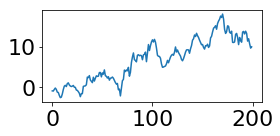

In [37]:
# Simulate GARCH
pars = [0.03123, 0.06123, 0.90123]
sz = 200

# simul
sdata = gml.simulate_2(pars, sz)

# Visual inspection
sdata.cumsum().plot(figsize=(4,2))
plt.tight_layout()

In [38]:
# Simple QML
qmlPars, qmlLLK = gml.estimate_garch(sdata, gml.GARCH_PP, update_freq=5, disp='off')

# Modified profile likelihood, profile likelihood, and estimated parameters: omega
lpO, lmO, phatLPO, phatLMO = gml.estimate_profile_and_modified_lik(sdata, omega=True)

# Modified profile likelihood, profile likelihood, and estimated parameters: gamma
lpG, lmG, phatLPG, phatLMG = gml.estimate_profile_and_modified_lik(sdata, omega=False)

# Modified profile likelihood, profile likelihood, and estimated parameters: beta
lpB, lmB, phatLPB, phatLMB = gml.estimate_profile_and_modified_lik_beta(sdata)

In [39]:
print('---------------')
print('True Parameters')
print(pars)
print('---------------')
print('Quasi-Likelihood estimation')
print('QML = %s'%qmlPars)
print('----------------')
print('Focal parameter = OMEGA')
print('lp = %s'%phatLPO)
print('lm = %s'%phatLMO)
print('----------------')
print('Focal parameter = GAMMA')
print('lp = %s'%phatLPG)
print('lm = %s'%phatLMG)
print('----------------')
print('Focal parameter = BETA')
print('lp = %s'%phatLPB)
print('lm = %s'%phatLMB)

---------------
True Parameters
[0.03123, 0.06123, 0.90123]
---------------
Quasi-Likelihood estimation
QML = [0.0544815  0.11244386 0.8324479 ]
----------------
Focal parameter = OMEGA
lp = [0.05421053 0.11231782 0.8328851 ]
lm = [0.03947368 0.12052749 0.84412026]
----------------
Focal parameter = GAMMA
lp = [0.05465296 0.11315789 0.83165934]
lm = [0.37628215 0.06157895 0.50050102]
----------------
Focal parameter = BETA
lp = [0.05484205 0.11292148 0.83157895]
lm = [0.05483456 0.11291423 0.83157895]


# What's next 

In [8]:
# Pre-Assign
_Lp_parsO = []
_Lm_parsO = []

_Lp_parsG = []
_Lm_parsG = []

_Lp_parsB = []
_Lm_parsB = []


pars = [0.03123, 0.06123, 0.90123]
sz = 300

# SIMLATION
for i in range(50):
    # SIMULATE AND ESTIMATE
    sdata = gml.simulate_2(pars, sz)
    
    # Modified profile likelihood, profile likelihood, and estimated parameters: omega
    lpO, lmO, phatLPO, phatLMO = gml.estimate_profile_and_modified_lik(sdata, omega=True)

    # Modified profile likelihood, profile likelihood, and estimated parameters: gamma
    lpG, lmG, phatLPG, phatLMG = gml.estimate_profile_and_modified_lik(sdata, omega=False)

    # Modified profile likelihood, profile likelihood, and estimated parameters: beta
    lpB, lmB, phatLPB, phatLMB = gml.estimate_profile_and_modified_lik_beta(sdata)

    _Lp_parsO.append(phatLPO)
    _Lm_parsO.append(phatLMO)
    
    _Lp_parsG.append(phatLPG)
    _Lm_parsG.append(phatLMG)
    
    _Lp_parsB.append(phatLPB)
    _Lm_parsB.append(phatLMB)

In [15]:
pars

[0.03123, 0.06123, 0.90123]

In [9]:
pd.DataFrame(_Lp_parsO).std(axis=0)

0    0.046839
1    0.036349
2    0.083757
dtype: float64

In [10]:
pd.DataFrame(_Lm_parsO).mean(axis=0)

0    0.058926
1    0.068424
2    0.861701
dtype: float64

In [11]:
pd.DataFrame(_Lp_parsB).mean(axis=0)

0    0.099011
1    0.073156
2    0.802684
dtype: float64

In [12]:
pd.DataFrame(_Lm_parsB).mean(axis=0)

0    0.165563
1    0.073479
2    0.715053
dtype: float64

In [13]:
pd.DataFrame(_Lp_parsG).mean(axis=0)

0    0.097974
1    0.072189
2    0.804726
dtype: float64

In [14]:
pd.DataFrame(_Lm_parsG).mean(axis=0)

0    0.192302
1    0.062021
2    0.713929
dtype: float64

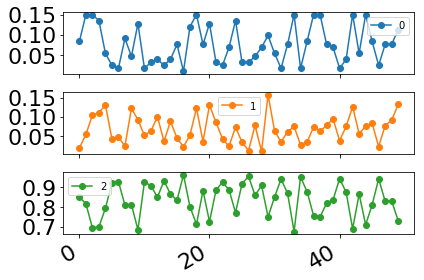

In [24]:
pd.DataFrame(_Lp_parsO).plot(subplots=True,marker='o')
plt.tight_layout()

# Opening up the QML Estimator

# GARCH(1,1) Model
def GARCH_PP(pars, data, sigma, out=None):
    # pormenores
    omega    = pars[0] # pars
    gamma    = pars[1] # pars
    beta     = pars[2] # pars

    # pormenores
    T = np.size(data,0)

    # ret = (y - mean)
    eps = data

    # The iteration
    for t in xrange(1,T):
        sigma[t] = omega + gamma * eps[t-1]**2 + beta * sigma[t-1]

    # The objective function
    logliks = 0.5 * (log(2 * pi) + log(sigma) + eps ** 2.0 / sigma)
    loglik = sum( logliks )
    if out is None:
        return loglik
    else:
        return loglik, logliks, copy(sigma)

# Estimating the GARCH(1,1) model
def estimate_garch(data, GARCH_PP, update_freq=5, disp='off'):

    # initial points
    pars = starting_values(data)

    # Initial args
    T = np.size(data, 0)
    sigma = np.repeat(np.var(data), T)
    args = (data, sigma)

    # 4. Estimate models using constrained optimization
    global _callback_func_count, _callback_iter, _callback_iter_display
    _callback_func_count, _callback_iter = 0, 0
    if update_freq <= 0 or disp == 'off':
        _callback_iter_display = 2 ** 31
        update_freq = 0
    else:
        _callback_iter_display = update_freq
    disp = 1 if disp == 'final' else 0

    # Bounds
    bounds = ((0.01, 0.5),
              (0.01, 0.5),
              (0.5, 0.99))

    # Constrains
    cons = ({'type': 'ineq',
             'fun' : lambda x: np.array([x[0]])},
           {'type':'ineq',
            'fun': lambda x: np.array([x[1]])},
           {'type':'ineq',
            'fun': lambda x: np.array([x[2]])},
           {'type':'ineq',
            'fun': lambda x: np.array([1-x[1]-x[2]])}
            )

    # Estimate the model
    res = minimize(GARCH_PP, pars, args=args, constraints=cons, bounds=bounds,
                   method='SLSQP', callback=_callback, options={'ftol':1e-31,'disp': False})
    # Save parameters
    hat_pars = res.x
    logLik = res.fun

    return hat_pars, logLik

# Opening up the LProfile Estimator

bounds QML estimator for all parameters = ((0.01, 0.5),(0.01, 0.5),(0.5, 0.99))

bounds LP Gamma = ((0.001, 0.5),(0.5, 0.99))

bounds LP Omega = ((0.001, 0.5),(0.5, 0.99))

profile Lik. Step for gamma_range = np.linspace(0.01,0.15,20)

profile Lik. Step for omega_range = np.linspace(0.01,0.15,20)

LM Fixed Gamma = ((0.001, 0.5),(0.5, 0.99))

Estimate Garch at fixed beta = ((0.001, 0.5),(0.001, 0.5))

Construct profile beta =  np.linspace(0.5, 0.95, 20)

Estimate GARCH LM Fixed Beta = ((0.001, 0.5), (0.001, 0.5))

beta_range = np.linspace(0.5, 0.95, 20)

Estimate Garch LM Fixed Omega = ((0.01, 0.5),(0.5, 0.99))

## Simulate everythin using QML 